In [2]:
regressors_to_remove = ["destinationMacAddress", "sourceMacAddress", "egressInterface", "ingressInterface", "initialTCPFlags", 
                    "reverseInitialTCPFlags", "reverseTcpUrgTotalCount", "reverseUnionTCPFlags", "silkAppLabel", 
                    "tcpSequenceNumber", "tcpUrgTotalCount", "unionTCPFlags", "vlanId", "sourceIPv4Address", 
                    "destinationIPv4Address", "reverseTcpSequenceNumber", "observationDomainId", "reverseStandardDeviationInterarrivalTime",
                    "reverseStandardDeviationPayloadLength", "reverseSmallPacketCount", "reverseNonEmptyPacketCount",
                    "reverseMaxPacketSize", "reverseLargePacketCount", "reverseFirstNonEmptyPacketSize", "reverseDataByteCount",
                    "reverseBytesPerPacket", "reverseAverageInterarrivalTime", "collectorName"]

regressor_has_null = ["protocolIdentifier"]

In [2]:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType, LongType, TimestampType

schema = StructType([
    StructField("averageInterarrivalTime", DoubleType(), True),
    StructField("bytesPerPacket", DoubleType(), True),
    StructField("dataByteCount", DoubleType(), True),
    StructField("destinationTransportPort", IntegerType(), True),
    StructField("firstEightNonEmptyPacketDirections", StringType(), True),
    StructField("firstNonEmptyPacketSize", DoubleType(), True),
    StructField("flowAttributes", StringType(), True),
    StructField("flowDurationMilliseconds", DoubleType(), True),
    StructField("flowEndMilliseconds", TimestampType(), True),
    StructField("flowEndReason", StringType(), True),
    StructField("flowStartMilliseconds", TimestampType(), True),
    StructField("ipClassOfService", StringType(), True),
    StructField("largePacketCount", DoubleType(), True),
    StructField("maxPacketSize", DoubleType(), True),
    StructField("nonEmptyPacketCount", DoubleType(), True),
    StructField("octetTotalCount", IntegerType(), True),
    StructField("packetTotalCount", IntegerType(), True),
    StructField("protocolIdentifier", IntegerType(), True),
    StructField("reverseFlowAttributes", StringType(), True),
    StructField("reverseFlowDeltaMilliseconds", DoubleType(), True),
    StructField("reverseOctetTotalCount", IntegerType(), True),
    StructField("reversePacketTotalCount", IntegerType(), True),
    StructField("smallPacketCount", DoubleType(), True),
    StructField("sourceTransportPort", IntegerType(), True),
    StructField("standardDeviationInterarrivalTime", DoubleType(), True),
    StructField("standardDeviationPayloadLength", DoubleType(), True),
    StructField("response", StringType(), True)
])

In [36]:
import os
import re
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("cleanData").getOrCreate()



folder_path = 'C:\\Users\\Priyash Shah\\Downloads\\DATA3001 Project Data\\Extracted Data'
data_lengths = []
# Get all files in the directory
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#df = spark.createDataFrame(spark.sparkContext.emptyRDD(),schema)
df = pd.DataFrame()
for file in files:
    print(f"in file {file}")
    file_path = folder_path+'\\'+file
    data = []
    length = 0
    ### TEMP
    dataset = open(file_path)
    
    # Read file line by line based on date
    for line in dataset:
        obj = json.loads(line)
        
        if 'flows' in obj:
           
            dateflow = obj['flows']['flowEndMilliseconds']
            if dateflow > "2019-07-26":
                break
            length += 1    
            data.append(obj['flows'])
        else:
            break
    
    response = re.sub('([^.]*).json$', r'\1', file)
    data_info = (response, length)        
    data_lengths.append(data_info)
    
    # Assuming data is already loaded
    temp_df = pd.DataFrame(data)

    # Sampling
    temp_df = temp_df.sample(n = 4500, random_state=69)

    # print(temp_df.columns)
    # Dropping columns
    for regressors in regressors_to_remove:
        temp_df = temp_df.drop(columns=regressors)

    # Dropping rows with all NaN values in the specified columns
    for regressors in regressor_has_null:
        temp_df = temp_df.dropna(how='all', subset=[regressors])
    temp_df['response'] = response    
    df = pd.concat([df, temp_df], ignore_index=True)
            
    '''       
    temp_df = spark.createDataFrame(data)
    
    sample_length = 4500 / len(data)
    temp_df = temp_df.sample(sample_length)
    temp_df.count()
    #print(obj.columns)
    #temp_df = pd.json_normalize(data)
    #temp_df = temp_df.sample(fraction=0.1, seed=69)
    for regressors in regressors_to_remove:
        temp_df = temp_df.drop(regressors)
    for regressors in regressor_has_null:  
        temp_df = temp_df.na.drop('all', subset=[regressors])
    response = re.sub('([^.]*).json$', r'\1', file)
    temp_df = temp_df.withColumn("response", lit(response))
    '''
    
   
    
    
    #pandas_df = temp_df.toPandas()
    
    #df = df.append(new_row, ignore_index=True)
    
    #df = df.union(temp_df)
    

in file amazon_echo_gen2.json
in file au_network_camera.json
in file au_wireless_adapter.json
in file bitfinder_awair_breathe_easy.json
in file candy_house_sesami_wi-fi_access_point.json
in file irobot_roomba.json
in file jvc_kenwood_hdtv_ip_camera.json
in file line_clova_wave.json
in file link_japan_eremote.json
in file mouse_computer_room_hub.json
in file nature_remo.json
in file panasonic_doorphone.json
in file philips_hue_bridge.json
in file planex_camera_one_shot!.json
in file planex_smacam_outdoor.json
in file planex_smacam_pantilt.json
in file powerelectric_wi-fi_plug.json
in file qrio_hub.json
in file sony_network_camera.json


In [21]:
data_lengths

[('amazon_echo_gen2', 142356),
 ('au_network_camera', 71903),
 ('au_wireless_adapter', 154371),
 ('bitfinder_awair_breathe_easy', 68896),
 ('candy_house_sesami_wi-fi_access_point', 46116),
 ('irobot_roomba', 40818),
 ('jvc_kenwood_hdtv_ip_camera', 42982),
 ('line_clova_wave', 64244),
 ('link_japan_eremote', 70545),
 ('mouse_computer_room_hub', 4610),
 ('nature_remo', 40867),
 ('panasonic_doorphone', 357568),
 ('philips_hue_bridge', 72750),
 ('planex_camera_one_shot!', 430580),
 ('planex_smacam_outdoor', 48014),
 ('planex_smacam_pantilt', 33523),
 ('powerelectric_wi-fi_plug', 78091),
 ('qrio_hub', 51951),
 ('sony_network_camera', 45014)]

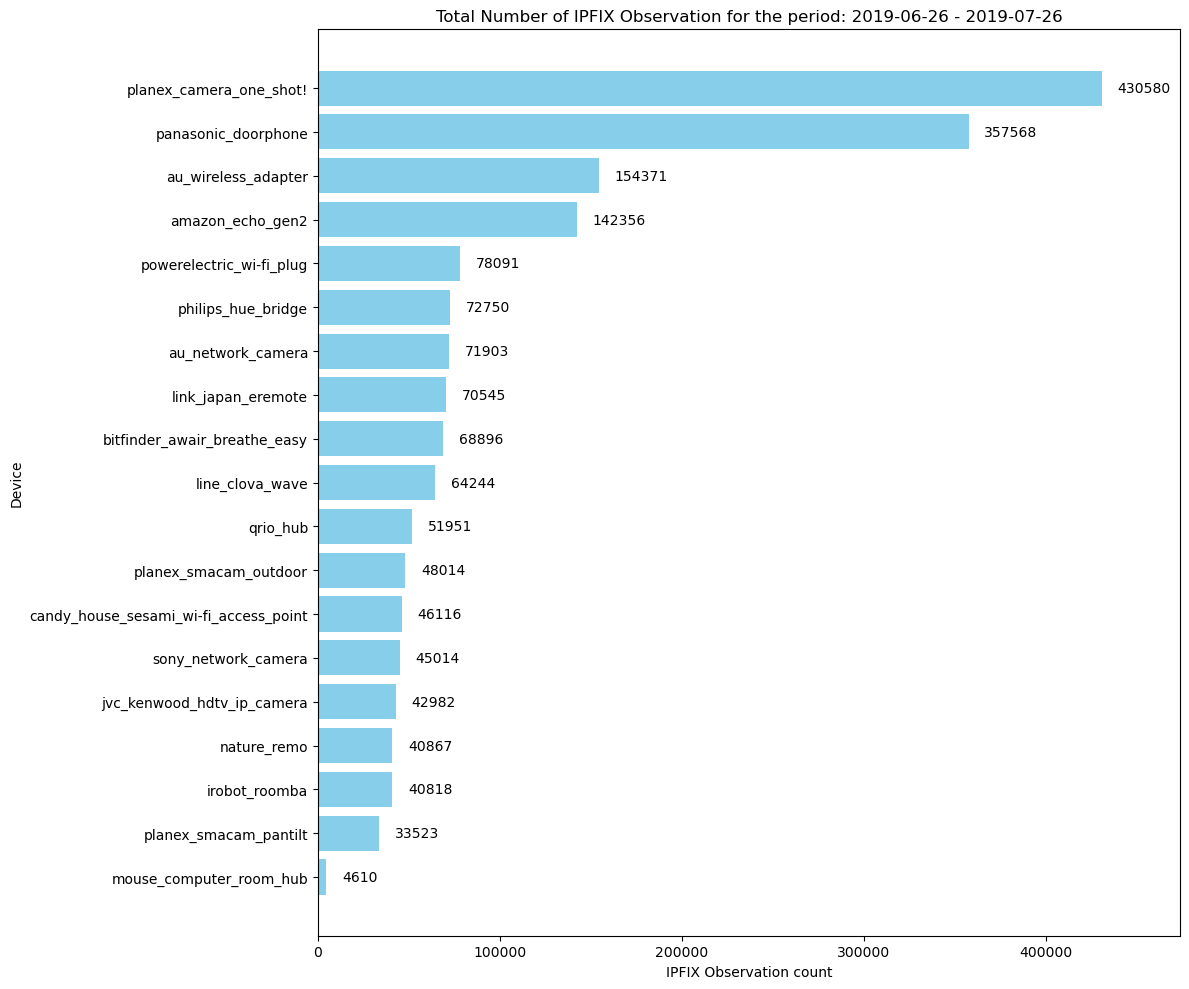

In [22]:

import matplotlib.pyplot as plt


data_lengths = pd.DataFrame(data_lengths, columns=['Name', 'Count'])

# Sort by Count
data_lengths = data_lengths.sort_values('Count', ascending=True)

plt.figure(figsize=(12, 10))
bars = plt.barh(data_lengths['Name'], data_lengths['Count'], color='skyblue')

# Set the x-axis limit to accommodate the annotations (e.g., increase by 10%)
plt.xlim(0, data_lengths['Count'].max() * 1.1)

# Annotate each bar with its exact count
for bar in bars:
    plt.text(bar.get_width() + (0.02 * data_lengths['Count'].max()),  # Position the text a bit right from the bar's end
             bar.get_y() + bar.get_height()/2,  # Y location in the middle of the bar
             f'{int(bar.get_width())}',  # Value to display
             va='center', ha='left',  # Vertical and horizontal alignment
             color='black', fontsize=10)

plt.xlabel('IPFIX Observation count')
plt.ylabel('Device')
plt.title('Total Number of IPFIX Observation for the period: 2019-06-26 - 2019-07-26')
plt.tight_layout()
plt.show()



In [28]:
ordered_protcol_identifiers = df['protocolIdentifier'].value_counts()

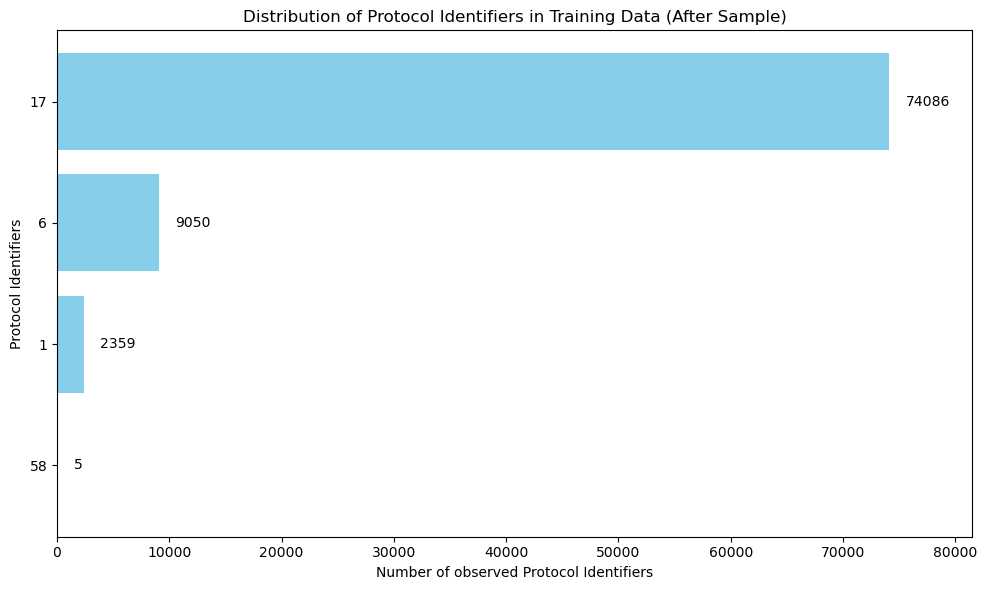

In [35]:
plt.figure(figsize=(10, 6))
ordered_protcol_identifiers = {
    'Category': [17, 6, 1, 58],
    'Count': [74086, 9050, 2359, 5]
}

ordered_protcol_identifiers = pd.DataFrame(ordered_protcol_identifiers)
ordered_protcol_identifiers = ordered_protcol_identifiers.sort_values('Count', ascending=True)
ordered_protcol_identifiers['Category'] = ordered_protcol_identifiers['Category'].astype(str)

bars = plt.barh(ordered_protcol_identifiers['Category'], ordered_protcol_identifiers['Count'], color='skyblue')



# Set the x-axis limit to accommodate the annotations (e.g., increase by 10%)
plt.xlim(0, ordered_protcol_identifiers['Count'].max() * 1.1)

# Annotate each bar with its exact count
for bar in bars:
    plt.text(bar.get_width() + (0.02 * ordered_protcol_identifiers['Count'].max()),  # Position the text a bit right from the bar's end
             bar.get_y() + bar.get_height()/2,  # Y location in the middle of the bar
             f'{int(bar.get_width())}',  # Value to display
             va='center', ha='left',  # Vertical and horizontal alignment
             color='black', fontsize=10)

plt.xlabel('Number of observed Protocol Identifiers')
plt.ylabel('Protocol Identifiers')
plt.title('Distribution of Protocol Identifiers in Training Data (After Sample)')
plt.tight_layout()
plt.show()

In [ ]:
# Observing the most popular clothing collections (sections)
import seaborn as sns
ordered_protcol_identifiers = df['protocolIdentifier'].value_counts()

f, ax = plt.subplots(figsize=(14, 14))
sns.histplot(data=articles, y='section_name', bins=len(ordered_section_names))
ax.set_xlabel('count of articles by clothing collection')
ax.set_ylabel('section_name')
plt.show()



In [23]:
start_time = "2019-06-25 09:00:00"
end_time = "2019-06-29 10:00:00"

filtered_df = df.filter((col("flowStartMilliseconds") >= start_time) & 
                        (col("flowStartMilliseconds") <= end_time))


In [12]:
df

,flowStartMilliseconds,flowEndMilliseconds,flowDurationMilliseconds,reverseFlowDeltaMilliseconds,protocolIdentifier,sourceTransportPort,packetTotalCount,octetTotalCount,flowAttributes,destinationTransportPort,...,nonEmptyPacketCount,dataByteCount,averageInterarrivalTime,firstNonEmptyPacketSize,largePacketCount,maxPacketSize,firstEightNonEmptyPacketDirections,standardDeviationPayloadLength,standardDeviationInterarrivalTime,bytesPerPacket
0,2019-06-27 21:53:01.806,2019-06-27 21:53:01.826,0.020,0.000,1,0,10,840,01,0,...,10.0,560.0,2.0,56.0,0.0,56.0,00,0.0,1.0,56.0
1,2019-07-13 19:47:21.040,2019-07-13 19:49:26.611,125.571,0.174,6,46185,23,4777,00,443,...,5.0,3765.0,498.0,517.0,4.0,1360.0,7e,411.0,467.0,753.0
2,2019-07-10 11:16:20.373,2019-07-10 11:21:20.736,300.363,0.176,6,51448,9,684,01,80,...,2.0,292.0,37523.0,146.0,0.0,146.0,0e,0.0,90712.0,146.0
3,2019-07-04 04:29:36.366,2019-07-04 04:34:36.783,300.417,0.178,6,34505,9,684,01,80,...,2.0,292.0,37530.0,146.0,0.0,146.0,0e,0.0,90666.0,146.0
4,2019-07-12 01:10:42.809,2019-07-12 01:10:52.801,9.992,0.000,17,23600,2,120,01,53,...,2.0,64.0,9992.0,32.0,0.0,32.0,00,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85495,2019-07-07 14:18:39.536,2019-07-07 14:18:40.111,0.575,0.000,17,38298,2,156,01,137,...,2.0,100.0,575.0,50.0,0.0,50.0,00,0.0,0.0,50.0
85496,2019-07-25 18:53:55.947,2019-07-25 18:53:56.534,0.587,0.000,17,45093,2,156,01,137,...,2.0,100.0,587.0,50.0,0.0,50.0,00,0.0,0.0,50.0
85497,2019-07-15 18:31:11.745,2019-07-15 18:31:11.936,0.191,0.000,17,52323,6,1958,00,1900,...,6.0,1790.0,38.0,282.0,6.0,322.0,00,17.0,32.0,298.0
85498,2019-07-24 19:37:10.067,2019-07-24 19:37:10.647,0.580,0.000,17,60684,2,156,01,137,...,2.0,100.0,580.0,50.0,0.0,50.0,00,0.0,0.0,50.0


In [ ]:
df.count()

In [24]:
unique_values = filtered_df.select("response").distinct().rdd.flatMap(lambda x: x).collect()

for value in unique_values:
    print(value)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 49.0 failed 1 times, most recent failure: Lost task 0.0 in stage 49.0 (TID 958) (129.94.204.167 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more
